This code only works when direction == 'UD' for now

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.io import loadmat
import pandas as pd
from scipy.ndimage import gaussian_filter
import os
%matplotlib inline

In [2]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

# load files 

In [3]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\'


In [4]:
cn = 32

In [5]:
ExpData = loadmat(exp_folder+'merge\\merge_0224_Checkerboard_30Hz_27_15min_Br50_Q100_re', squeeze_me =True)

# GF before SVD

In [6]:
checkerboard = ExpData['bin_pos']
fs = 1.5
GFcheckerboard = np.array([gaussian_filter(cb.astype(float), fs) for cb in checkerboard])
# GFcheckerboard = np.array([cb.astype(float) for cb in checkerboard])
GFCcheckerboard = GFcheckerboard - np.mean(GFcheckerboard, axis = 0)
dt = 1/60
rstate, _ = np.histogram(ExpData['reconstruct_spikes'][cn-1], np.arange(len(checkerboard)+1)*dt)
Taxis = np.arange(60)*dt

In [7]:
STK = np.zeros([60,27,27])
for i in range(60): #1s
    for ii in np.arange(0, len(checkerboard)-i):
        STK[i,:,:] += rstate[ii+i]*GFCcheckerboard[ii,:,:]
    STK[i,:,:] /= np.sum(rstate[:len(checkerboard)-i])

In [8]:
rSTK = STK.reshape((-1,27*27))
U,sigma,VT=np.linalg.svd(rSTK)

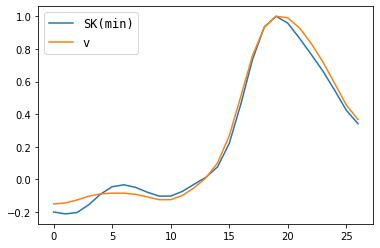

In [9]:
argminSKcut = np.squeeze(STK[np.where(STK == np.min(STK))[0], :, np.where(STK == np.min(STK))[2]])
plt.plot(argminSKcut/ min(argminSKcut), label='SK(min)')
vb = VT[0,:].reshape((27,27))
vcutb = vb[:, np.where(STK == np.min(STK))[2]]
plt.plot(vcutb/ max(vcutb), label='v')


plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})
TheFig = plt.gcf()
TheAx = plt.gca()

# GF after SVD

In [10]:
checkerboard = ExpData['bin_pos']
fs = 3
GFcheckerboard = np.array([cb.astype(float) for cb in checkerboard])
# GFcheckerboard = np.array([cb.astype(float) for cb in checkerboard])
GFCcheckerboard = GFcheckerboard - np.mean(GFcheckerboard, axis = 0)
dt = 1/60
rstate, _ = np.histogram(ExpData['reconstruct_spikes'][cn-1], np.arange(len(checkerboard)+1)*dt)
Taxis = np.arange(60)*dt

In [11]:
STK = np.zeros([60,27,27])
for i in range(60): #1s
    for ii in np.arange(0, len(checkerboard)-i):
        STK[i,:,:] += rstate[ii+i]*GFCcheckerboard[ii,:,:]
    STK[i,:,:] /= np.sum(rstate[:len(checkerboard)-i])

In [12]:
rSTK = STK.reshape((-1,27*27))
U,sigma,VT=np.linalg.svd(rSTK)

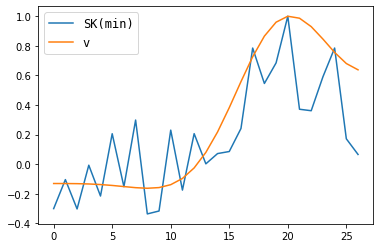

In [13]:
argminSKcut = np.squeeze(STK[np.where(STK == np.min(STK))[0], :, np.where(STK == np.min(STK))[2]])
plt.plot(argminSKcut/ min(argminSKcut), label='SK(min)')
va = gaussian_filter(VT[0,:].reshape((27,27)),fs)
# va = VT[0,:].reshape((27,27))
vcuta = va[:, np.where(STK == np.min(STK))[2]]
plt.plot(vcuta/ max(vcuta), label='v')


plt.legend(loc='best', prop={'size': 'large', 'family': 'monospace'})


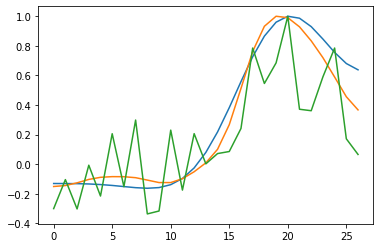

In [14]:
plt.plot(vcuta/ max(vcuta))
plt.plot(vcutb/ max(vcutb))
plt.plot(argminSKcut/ min(argminSKcut), label='SK(min)')

[ 0.15697361 20.24248996  3.42433704]


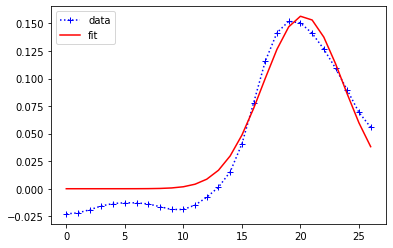

In [15]:
from scipy.optimize import curve_fit

def GF1d(x, a, x0, s):
    return  a*(np.exp(-((x-x0)/s)**2/2))

xaxis = np.arange(27.)
popt,pcov = curve_fit(GF1d, xaxis, np.squeeze(vcutb),
                      p0=[max(vcutb), 15., 3.], bounds = (0, np.inf))
# popt,pcov = curve_fit(DoG, SKxaxis, SK, p0=[max(SK)/2, 23, -0.1*max(SK), 5*23])
print(popt)
plt.plot(vcutb, 'b+:', label='data')
plt.plot(GF1d(xaxis, *popt), 'r-', label='fit')
plt.legend()

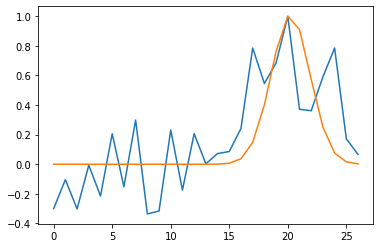

In [16]:
plt.plot(argminSKcut/ min(argminSKcut), label='SK(min)')
BackLag = GF1d(xaxis, *popt[:-1], np.sqrt(popt[-1]**2-fs**2))
plt.plot(BackLag/max(BackLag))